In [1]:
%matplotlib inline
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

In [2]:
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy import misc

In [3]:
#Extract object points and image points - FULL CREDIT TO UDACITY's/Ryan Keenan's Github

In [4]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('D:/Self Driving Car Engineer/P4/calibration_wide/GO*.jpg')


PATH= "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/camera_cal/"
images =os.listdir(PATH)

for i in range(len(images)):  
    img = (cv2.imread(PATH+images[i])) #original image
    # Step through the list and search for chessboard corners
    #for idx, fname in enumerate(images):
    #img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    
    #save  the points for further use
    np.save('D:/Self Driving Car Engineer/P4/data/objpoints', objpoints)
    np.save('D:/Self Driving Car Engineer/P4/data/imgpoints', imgpoints)

cv2.destroyAllWindows()

In [5]:
def undistort(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    calibration = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None) #gives calibration matrix
    return cv2.undistort(img, calibration[1] , calibration[2], None, calibration[1]) #takes calibration matrix, undistort image

In [6]:
#colour and gradient threshold

In [7]:
#All in one????

In [8]:
def threshold(img, s_thresh=(180, 253), sx_thresh=(15, 190)):

    #
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]


    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    


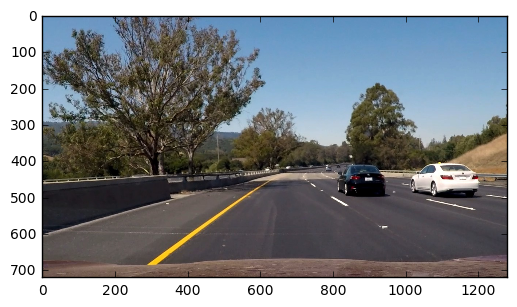

In [9]:
image = mpimg.imread('D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/test_images/test6.jpg')
plt.imshow(image) #the image is 1280 by 720

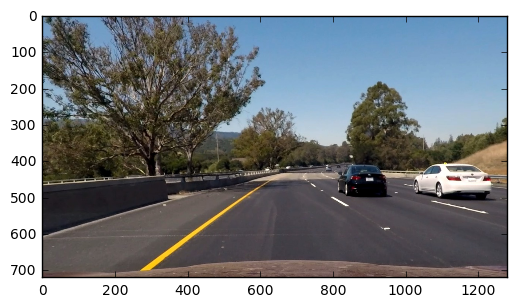

In [10]:
a = undistort(image)
plt.imshow(a) #image is undistorted slightly at the edges

In [11]:
#Perspective Transform

In [12]:
trapezium = src = np.float32([[580, 460],[700, 460],[1040, 680],[260, 680], ])

rectangle = np.float32([[260, 0],[1040, 0],[1040, 720],[260, 720],])

transform = cv2.getPerspectiveTransform(trapezium, rectangle)
INVtransform = cv2.getPerspectiveTransform(rectangle, trapezium)

def warp(img):
    # 
    trapezium = np.float32([[580, 460],[700, 460],[1040, 680],[260, 680], ])
    rectangle = np.float32([[260, 0],[1040, 0],[1040, 720],[260, 720],])
    transform = cv2.getPerspectiveTransform(trapezium, rectangle)
    INVtransform = cv2.getPerspectiveTransform(rectangle, trapezium)
    
    return cv2.warpPerspective(img, transform, (img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR)

In [13]:
def unwarp(img):
        return cv2.warpPersective(img, INVtransform,(img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR)

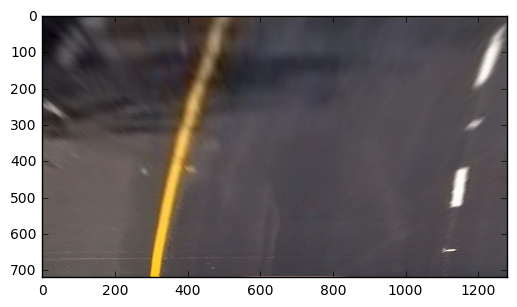

In [14]:
z = warp(a)
plt.imshow(z)

In [15]:
def pipeline(original):

    undistorted = undistort(original)
    misc.imsave('D:/Self Driving Car Engineer/P4/output_images/undistorted.jpg', undistorted)
     
    img = threshold(undistorted)
    misc.imsave('D:/Self Driving Car Engineer/P4/output_images/thresholded.jpg', img)

    binary_warped = warp(img)
    misc.imsave('D:/Self Driving Car Engineer/P4/output_images/warped.jpg', binary_warped)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #  Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    '''#plot the image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)'''
    
    
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    '''# Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)'''
    
    
    #drawing the lines  back onto the road
    # Create an image to draw the lines on
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #print('shape of warp zero')
    #print(warp_zero.shape)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print('shape of colour warp')
    #print(color_warp.shape)
    
    #color_warp = np.zeros_like(binary_warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print('these are points')
    #print(pts)
    pts = np.array(pts, dtype=np.int32)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0,255, 0))  #i used warp_zero instead of colour_warp

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, INVtransform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    #print('shape of newwarp')
    #print(newwarp.shape)
    
    #print('shape of undistorted')
    #print(undistorted.shape)
    
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    plt.imshow(result)
    
 
    
    return 

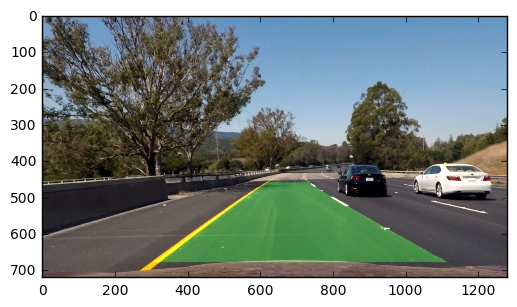

In [16]:
pipeline(image)

AttributeError: 'NoneType' object has no attribute 'shape'

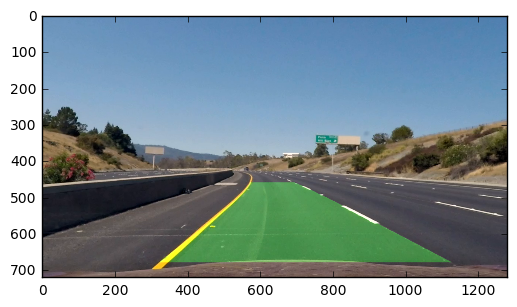

In [17]:
video = "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/project_video.mp4"
white_output = '{}_done_2.mp4'
#clip1 = VideoFileClip('{}.mp4'.format(video)).subclip(30, 51)
clip1 = VideoFileClip(video)

white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)